Test for Charilaou et al. (2011) J. Appl. Phys. 109, 093903

to do

SI単位系にする

全体の流れは次の通り：

結晶方位を基準にとった次のような座標系を考える。
z = [111] (easy axis), 
x = [-211], y = [0-11]
1. この単結晶に対し、ある方向$(\theta_H, \phi_H)$の磁場をかけ、磁化方位$(\theta, \phi)$を算出する。$(\theta, \phi)$はそれぞれz, xから測った角度。
2. 共鳴方程式から共鳴磁場強度$H_{res}$を算出する
3. 適当なline broadningから単粒子のスペクトルを計算する
4. 磁場の方位を変え（粒子の向きを変えるのと等価）、1, 2, 3を繰り返し和をとって、粒子集団のスペクトルを計算する。

1-2を詳細に書くと、磁場強度$H_0$によって磁化方位が変わるため、反復計算が必要になる。すなわち
1. 適当な磁場強度（例えば200mT)の磁場をかけて、磁化方位を計算
2. このときの$H_{res}$を計算
3. $H_{res} = H_0$ならこれが正しい共鳴磁場
4. そうでない場合、$H_0$を$H_{res}$で置き換えて再び1に戻る
5. 1-4を収束するまで繰り返す

In [1]:
import pandas as pd
import numpy as np
from numpy.random import rand
from scipy.optimize import fsolve
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
plt.rcParams["font.family"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True
# for presentation
plt.rcParams["font.size"] = 16

In [3]:
# constants
omega = 9.47e+9 * 2. * np.pi  # Microwave angular frequency 9.47 GHz
gamma = 1.76e+7 # [g/Oe]
og2 = (omega/gamma) ** 2

In [4]:
# appendixにあるエネルギーの微分式

def dthetaF(theta, phi, H0, theta_H, phi_H, Huni, Hcub, M): 
    # args = (phi=0, H0=1, theta_H=0, phi_H=0, Huni=1000, Hcub=250, M=470)  Hは[Oe], Mは[G]
    t1 = Huni * M *  np.cos(theta) * np.sin(theta)
    t2 = M * H0 * (np.cos(theta) * np.sin(theta_H) * np.cos(phi-phi_H) - np.cos(theta_H) * np.sin(theta))
    t3 = (1./12) * Hcub * M * np.sin(theta) * (9 * np.cos(theta) + 7 * np.cos(3*theta) - 4 * (2**0.5) * np.cos(3*phi) * np.sin(3*theta))
    return t1 - t2 - t3

def dphiF(phi, theta, H0, theta_H, phi_H, Hcub, M):
    t1 = M * H0 * np.sin(theta) * np.sin(theta_H) * np.sin(phi-phi_H)
    t2 = 2**0.5 * Hcub * M * np.cos(theta) * (np.sin(theta)**3) * np.cos(3*phi)
    return t1 - t2

def dthetadthetaF(theta, phi, H0, theta_H, phi_H, Huni, Hcub, M):
    t1 = Huni * M * np.cos(2*theta)
    t2 = M * H0 * (np.sin(theta) * np.sin(theta_H) * np.cos(phi-phi_H) + np.cos(theta_H * np.cos(theta)))
    t3 = (1./6) * Hcub * M * (-np.cos(2*theta) - 7 * np.cos(4*theta) - 2*(2**0.5) * np.cos(3*phi)
                              * (np.sin(2*theta) - 2 * np.sin(4*theta)))
    return t1 + t2 + t3

def dphidthetaF(theta, phi, H0, theta_H, phi_H, Huni, Hcub, M):
    t1 = M * H0 * np.cos(theta) * np.sin(theta_H) * np.sin(phi-phi_H)
    t2 = 2**0.5 * Hcub * M * np.sin(theta) * np.sin(3*phi) * np.sin(3*theta)
    return t1 + t2

def dthetadphiF(phi, theta, H0, theta_H, phi_H, Hcub, M):
    t1 = M * H0 * np.cos(theta) * np.sin(theta_H) * np.sin(phi-phi_H)
    t2 =  2**0.5 * (1 + 2 * np.cos(2*theta)) * np.sin(theta) * np.sin(theta) * np.sin(3*phi)
    return t1 - t2

def dphidphiF(phi, theta, H0, theta_H, phi_H, Hcub, M):
    t1 = M * H0 * np.sin(theta) * np.sin(theta_H) * np.cos(phi-phi_H)
    t2 = 3 * 2**0.5 * np.cos(theta) * np.sin(theta)**3 * np.cos(3*phi)
    return t1 - t2

In [5]:
# 平衡状態での磁化方位の計算
def equiblate_CWG11(theta_H, phi_H, H0, Huni=1000, Hcub=-250, M=470): # H in [Oe], M in [G]
    
    def func(x):
        theta = x[0]
        phi = x[1]
        y = [dthetaF(theta, phi, H0, theta_H, phi_H, Huni, Hcub, M)]
        y.append(dphiF(phi, theta, H0, theta_H, phi_H, Hcub, M))
        return np.reshape(y, 2)
    
    def fprime(x):
        theta = x[0]
        phi = x[1]
        y = [[dthetadthetaF(theta, phi, H0, theta_H, phi_H, Huni, Hcub, M), dphidthetaF(theta, phi, H0, theta_H, phi_H, Huni, Hcub, M)],
             [dthetadphiF(phi, theta, H0, theta_H, phi_H, Hcub, M), dphidphiF(phi, theta, H0, theta_H, phi_H, Hcub, M)]]
        y = np.reshape(y, (2, 2))
        return y
    
    theta = theta_H
    phi = phi_H
    #print(func((theta, phi)))
    
    x, infodict, ier, mesg = fsolve(func, [theta, phi], fprime=fprime, full_output=True)
    #print(infodict["nfev"])
    theta, phi = x
    #theta, phi = fsolve(func, [theta, phi])
    #print(func((theta, phi)))
    
    
    return theta, phi

In [6]:
# 共鳴方程式（６）

def cal_Hres_CWG11(theta, phi, theta_H, phi_H, search='left', Huni=1000, Hcub=-250): # H in [Oe]:
    
    z = (np.cos(theta_H) * np.cos(theta) + np.cos(phi-phi_H) * np.sin(theta_H) * np.sin(theta))
    t12 = (Huni - Hcub/6.) * np.cos(2*theta)
    t13 = Hcub/6. * (7 * np.cos(4*theta) + 2*(2**0.5) * np.cos(3*phi) * (np.sin(2*theta) - 2 * np.sin(4*theta)))
   
    t22 = (Huni - Hcub/6. - 7./6 * Hcub * np.cos(2*theta)) * np.cos(theta) * np.cos(theta)
    t23 = 2**0.5 / 6 * Hcub * np.cos(3*phi) * (np.sin(4*theta) - 8 * np.sin(2*theta))
       
    #ax^2 + bx + c = 0
    
    a = z*z
    b = (t12 - t13 + t22 + t23) * z
    c = (t12 - t13) * (t22 + t23) - og2
    
    d2 = b * b - 4 * a * c
    if d2 > 0:
        d = np.sqrt(d2)
    else:
        print(d2)
        d = 0
    
    if search is 'left':
        Hres = (-b - d) / (2 * a)
    else:
        Hres = (-b + d) / (2 * a)
    
    
    return Hres

共鳴方程式はぱっとみ複雑ですが、Hについて解くと思うとただの2次方程式になります。したがって一般に解が2つありうるのですが、普通のやり方ではH>0の解を使うことになります。

※ここで$H_{uni} = 4\pi MN_{eff}$, $H_{cub} = K_1/M$。また論文ではt22項で分母に12が来ているが、2017年の論文では分母が6になっているのでそちらを使用（だれか検算してください）。

In [7]:
# 磁化方位と共鳴磁場を同時に解く

def find_Hres_CWG11(H0, theta_H, phi_H, search='left', Huni=1105, Hcub=-80, M=470):
    
    def func(H):
        theta, phi = equiblate_CWG11(theta_H, phi_H, H, Huni=Huni, Hcub=Hcub, M=M)
        #Hre = cal_Hres_CWG11(theta, phi, theta_H, phi_H, search=search, Huni=Huni, Hcub=Hcub, M=M)
        Hre = cal_Hres_CWG11(theta, phi, theta_H, phi_H, search=search, Huni=Huni, Hcub=Hcub)
        #return np.abs(H) - np.abs(Hre)
        return H - Hre
    
    Hres = fsolve(func, H0)
    return Hres

In [8]:
#コーシー分布型のLine broadening

def cal_S_Lorentz(H0, Hres, delta_H):
    return 2. * delta_H / (np.pi * (4. * (H0 - Hres)**2 + delta_H**2))

In [9]:
#正規分布型のLine broadening
def cal_S_Gaussian(H0, Hres, dHpp): # dHpp (peak-peak) = 2*sigma (standard deviation)
    return norm.pdf(H0, loc=Hres, scale=dHpp/2.)

In [10]:
# ランダムな向きを持った磁場をn個生成
n = 5000
spam = rand(n)
theta_H_arr = np.arccos(spam)
phi_H_arr = rand(n) * 2. * np.pi
df = pd.DataFrame(data={'theta_H': theta_H_arr, 'phi_H': phi_H_arr})
#plt.hist(np.degrees(theta_H_arr))
#plt.show()

In [11]:
H0 = 2500 # guess
a = []
for theta_H, phi_H in zip(theta_H_arr, phi_H_arr):
    a.append(find_Hres_CWG11(H0, theta_H, phi_H, search='right', Huni=1256, Hcub=-260, M=470))
df['right'] = a
#a = []
#for theta_H, phi_H in zip(theta_H_arr, phi_H_arr):
#    a.append(find_Hres_CWG11(H0, theta_H, phi_H, search='right', Huni=1105, Hcub=-80, M=470))
#df['right'] = a

In [12]:
a = []
b = []
for theta_H, phi_H, Hres in zip(theta_H_arr, phi_H_arr, df["right"].values):
    theta, phi = equiblate_CWG11(theta_H, phi_H, Hres, Huni=1256, Hcub=-260, M=470)
    a.append(theta)
    b.append(theta)
df["theta"] = a
df["phi"] = b

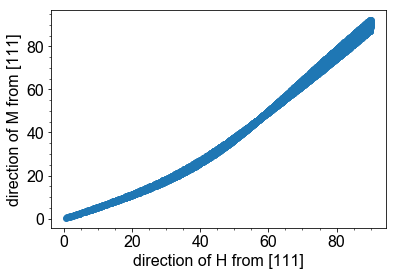

In [13]:
ax = plt.subplot(111)
ax.plot(np.degrees(df['theta_H']), np.degrees(df['theta']), 'o')
ax.set_xlabel(r'direction of H from [111]')
ax.set_ylabel(r'direction of M from [111]')
plt.show()

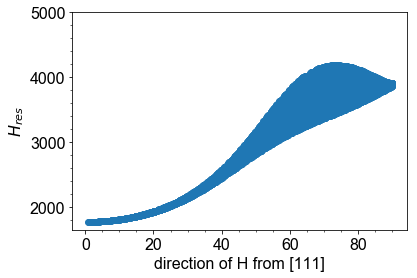

In [14]:
ax = plt.subplot(111)
ax.plot(np.degrees(df['theta_H']), df['right'], 'o')
ax.set_ylim(top=5000)
ax.set_xlabel(r'direction of H from [111]')
ax.set_ylabel(r'$H_{res}$')
plt.show()

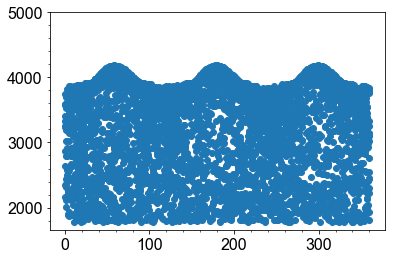

In [15]:
ax = plt.subplot(111)
ax.plot(np.degrees(df['phi_H']), df['right'], 'o')
ax.set_ylim(top=5000)
#ax.plot(df['theta_H'], df['right'], 'o')
plt.show()

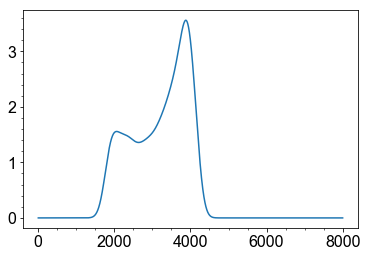

In [16]:
S = np.zeros(4096)
H0 = np.linspace(0, 8000, num=4096)
for Hres in df['right'].values:
    if Hres>0:
        #S += cal_S_Lorentz(H0, Hres, 150)
        S += cal_S_Gaussian(H0, Hres, 300)

ax = plt.subplot(111)
ax.plot(H0, S)
plt.show()

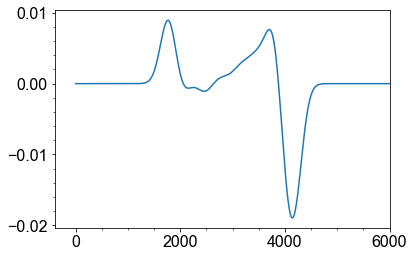

In [17]:
ax = plt.subplot(111)
ax.plot(H0[1:], np.diff(S))
ax.set_xlim(right=6000)
plt.show()

※これは論文の図4(b)に対応する結果ですが、実は$\Delta H_{pp}$を300にして計算してあります。論文の記述の通り150とすると下のようになります

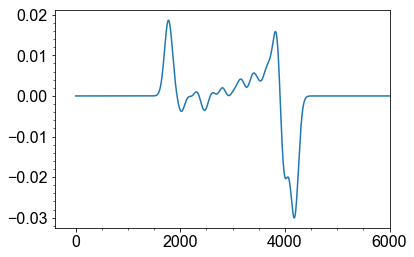

In [18]:
S = np.zeros(4096)
H0 = np.linspace(0, 8000, num=4096)
for Hres in df['right'].values:
    if Hres>0:
        #S += cal_S_Lorentz(H0, Hres, 150)
        S += cal_S_Gaussian(H0, Hres, 150)
ax = plt.subplot(111)
ax.plot(H0[1:], np.diff(S))
ax.set_xlim(right=6000)
plt.show()